## DECISION TREE

In [1]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
import sexmachine.detector as gender
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline 

Kişinin adını kullanarak cinsiyeti tahmin etme fonksiyonu

In [2]:
def predict_sex(name):
    sex_predictor = gender.Detector(unknown_value=u"unknown",case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code

Öğrenme Eğrisi için Fonksiyon

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Confusion Matrix çizmek için Fonksiyon

In [4]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ROC eğrisini çizmek için fonksiyon

In [5]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
print("Veri Seti Okunuyor.....\n")
genuine_users = pd.read_csv(r"C:\Users\Asus\Desktop\users.csv")
fake_users = pd.read_csv(r"C:\Users\Asus\Desktop\fusers.csv")
print("Gerçek Kullanıcı sütunları")
print(genuine_users.columns)
print("Gerçek Kullanıcı")
print(genuine_users.describe())
print("Sahte Kullanıcı")
print(fake_users.describe())
x=pd.concat([genuine_users,fake_users])   
y=len(fake_users)*[0] + len(genuine_users)*[1]

Veri Seti Okunuyor.....

Gerçek Kullanıcı sütunları
Index([u'id', u'name', u'screen_name', u'statuses_count', u'followers_count',
       u'friends_count', u'favourites_count', u'listed_count', u'created_at',
       u'url', u'lang', u'time_zone', u'location', u'default_profile',
       u'default_profile_image', u'geo_enabled', u'profile_image_url',
       u'profile_banner_url', u'profile_use_background_image',
       u'profile_background_image_url_https', u'profile_text_color',
       u'profile_image_url_https', u'profile_sidebar_border_color',
       u'profile_background_tile', u'profile_sidebar_fill_color',
       u'profile_background_image_url', u'profile_background_color',
       u'profile_link_color', u'utc_offset', u'protected', u'verified',
       u'description', u'updated', u'dataset'],
      dtype='object')
Gerçek Kullanıcı
                 id  statuses_count  followers_count  friends_count  \
count  1.481000e+03     1481.000000      1481.000000    1481.000000   
mean   4.00043

In [7]:
print("Öznitelik Çıkarımı.....\n")
lang_list = list(enumerate(np.unique(x['lang'])))   
lang_dict = { name : i for i, name in lang_list }             
x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
x.loc[:,'sex_code']=predict_sex(x['name'])
feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
x=x.loc[:,feature_columns_to_use]
print(x.columns)
print(x.describe())

Öznitelik Çıkarımı.....

Index([u'statuses_count', u'followers_count', u'friends_count',
       u'favourites_count', u'listed_count', u'sex_code', u'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.180270     2.85131

In [8]:
print("Veriseti train ve test verisi olarak ayrılıyor...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

Veriseti train ve test verisi olarak ayrılıyor...



In [9]:
print("Veri seti Eğitiliyor.......\n")
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred =clf.predict(X_test)

Veri seti Eğitiliyor.......



In [10]:
print("Test Veriseti Accuracy: ") ,accuracy_score(y_test, y_pred)

Test Veriseti Accuracy:  0.9060283687943262


Confusion matrix->Normalizasyon Olmadan
[[240  28]
 [ 25 271]]


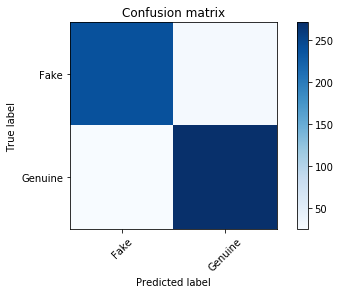

In [11]:
cm=confusion_matrix(y_test, y_pred)
print("Confusion matrix->Normalizasyon Olmadan")
print(cm)
plot_confusion_matrix(cm)

Normalize edilince ->  confusion matrix
[[0.89552239 0.10447761]
 [0.08445946 0.91554054]]


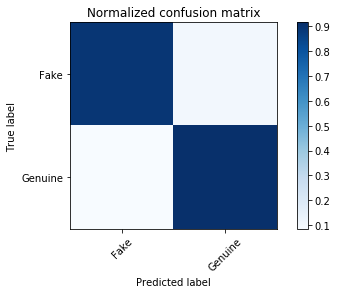

In [13]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalize edilince ->  confusion matrix")
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [14]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.91      0.90      0.90       268
     Genuine       0.91      0.92      0.91       296

   micro avg       0.91      0.91      0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564



('False Positive rate: ', array([0.        , 0.10447761, 1.        ]))
('True Positive rate: ', array([0.        , 0.91554054, 1.        ]))


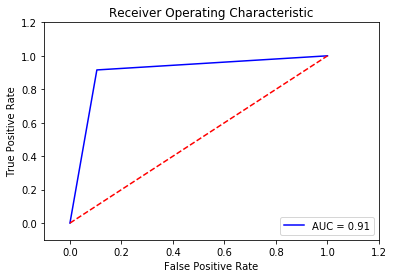

In [15]:
plot_roc_curve(y_test, y_pred)